In [1]:
import pandas as pd
import numpy as np
from statistics import mode
import scipy.stats as st
import sqlite3
import matplotlib
from datetime import date

In [2]:
%run ./transform_and_create_tables.ipynb

<class 'str'>


/tmp/ipykernel_54686/3054090517.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_originacao.VLCONTRATO = base_originacao.VLCONTRATO.str.replace('.', '').str.replace(',', '.').apply(lambda x: float(x))
/tmp/ipykernel_54686/3054090517.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_originacao.VLPARCELA = base_originacao.VLPARCELA.str.replace('.', '').str.replace(',', '.').apply(lambda x: float(x))
/tmp/ipykernel_54686/3054090517.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_carteira.VLCONTRATO =

In [3]:
conn = sqlite3.connect('teste_ailos.db')

base_originacao = pd.read_sql_query("SELECT * FROM base_originacao", conn)
base_carteira = pd.read_sql_query("SELECT * FROM base_carteira", conn)

In [4]:
%reload_ext sql
%sql sqlite:///teste_ailos.db

# RESOLUÇÃO DO EXERCÍCIO EM SQL
Em uma visão mensal (DTBASE), para o atributo QTPARCELAS, crie uma tabela contendo a Moda, e para o atributo SDDEVEDOR obtenha a Média e o Intervalo de Confiança para a média com nível de 99%. 
Unifique os resultados em uma única tabela. Além, escolha um mês para interpretar os resultados

In [5]:
%%sql
with all_data as (
    select 
        date(DTBASE) as DTBASE
        ,bc.SDDEVEDOR
        ,bo.QTPARCELAS
    from 
        base_carteira bc
    inner join 
        base_originacao bo 
            on bc.CONTRATO = bo.CONTRATO
            and bc.CPF = bo.CPF
            and bc.CONTA = bo.CONTA
            and bc.COOPERATIVA = bo.COOPERATIVA
            and bc.DTCONTRATO = bo.DTCONTRATO
            and bc.VLCONTRATO = bo.VLCONTRATO
    order by 
        date(DTBASE) asc
),

sizes as (
    select 
        DTBASE
        ,count(*) as size
    from 
        all_data 
    group by 
        DTBASE
),

averages as (
    select 
        DTBASE
        ,avg(SDDEVEDOR) as avg
    from 
        all_data
    group by 
        DTBASE
),

stds as (
    select 
        DTBASE
        ,size
        ,sqrt(sum(prep_std) / size) as std
    from 
    (
        select 
            all_data.DTBASE
            ,SDDEVEDOR
            ,avg 
            ,size
            ,power(SDDEVEDOR - avg, 2) prep_std
        from 
            all_data
        inner join 
            averages
                on all_data.DTBASE = averages.DTBASE
        inner join 
            sizes
                on all_data.DTBASE = sizes.DTBASE
    ) x
    group by 
        DTBASE
),

ranking_qtparcelas as (
    select 
        DTBASE
        ,QTPARCELAS
        ,Qnt
        ,dense_rank() over(partition by DTBASE order by Qnt desc) as rnk
    from 
    (
        select 
            DTBASE
            ,QTPARCELAS
            ,count(*) as Qnt
        from
            all_data 
        group by 
            DTBASE
            ,QTPARCELAS
        order by
            DTBASE
            ,3 desc
    ) x
)

select 
    averages.DTBASE
--  ,sizes.size
--  ,stds.std
    ,ranking_qtparcelas.QTPARCELAS as mode_qt_parcelas
    ,averages.avg as avg_sddev
    ,averages.avg + (2.57583 * (stds.std/sqrt(sizes.size))) as high_confidence_level
    ,averages.avg - (2.57583 * (stds.std/sqrt(sizes.size))) as low_confidence_level
from 
    averages
inner join 
    sizes
        on averages.DTBASE = sizes.DTBASE
inner join 
    stds
        on averages.DTBASE = stds.DTBASE
inner join 
    ranking_qtparcelas
        on ranking_qtparcelas.DTBASE = averages.DTBASE
where
    ranking_qtparcelas.rnk = 1
group by 
    averages.DTBASE

 * sqlite:///teste_ailos.db
Done.


DTBASE,mode_qt_parcelas,avg_sddev,high_confidence_level,low_confidence_level
2021-01-31,48.0,3965.1038703870418,4301.612151160229,3628.5955896138544
2021-02-28,48.0,3916.8703659268176,4219.036686650078,3614.704045203557
2021-03-31,48.0,3998.24128924701,4317.287272394661,3679.195306099359
2021-04-30,48.0,4098.543952483807,4435.474494097745,3761.613410869868
2021-05-31,48.0,4201.739054290721,5100.172715411477,3303.305393169964
2021-06-30,48.0,3970.6324655436356,4267.655248964635,3673.609682122636
2021-07-31,48.0,4180.992969334332,4525.476433023418,3836.5095056452456
2021-08-31,48.0,4184.65462490896,4522.139059622434,3847.170190195486
2021-09-30,48.0,4043.0856016693765,4366.361737179563,3719.8094661591904
2021-10-31,48.0,4073.589897610925,4421.320984047879,3725.858811173971


# RESOLUÇÃO DO EXERCÍCIO EM PYTHON
Em uma visão mensal (DTBASE), para o atributo QTPARCELAS, crie uma tabela contendo a Moda, e para o atributo SDDEVEDOR obtenha a Média e o Intervalo de Confiança para a média com nível de 99%. 
Unifique os resultados em uma única tabela. Além, escolha um mês para interpretar os resultados

In [6]:
all_data = base_carteira.merge(base_originacao[['CONTRATO', 'CPF', 'CONTA', 'COOPERATIVA', 'DTCONTRATO', 'VLCONTRATO', 'QTPARCELAS']], how='inner', on=['CONTRATO', 'CPF', 'CONTA', 'COOPERATIVA', 'DTCONTRATO', 'VLCONTRATO'])

z_value = 2.57583


all_data = all_data[['DTBASE', 'QTPARCELAS', 'SDDEVEDOR', 'CONTRATO']]

In [7]:
def get_confidence_level(avg, z, s, size):
    high_level = avg + z * (s / np.sqrt(size))
    low_level = avg - z * (s / np.sqrt(size))

    return (high_level, low_level)

In [8]:
consol_table = all_data.groupby('DTBASE').agg(
                                avg_sddev=('SDDEVEDOR', 'mean'), 
                                mode_qt_parcelas=('QTPARCELAS', mode),
                                std_sddev=('SDDEVEDOR', 'std'),
                                qnt=('CONTRATO', 'count')).reset_index()

In [9]:
consol_table['low_confidence_level'] = consol_table.apply(lambda x: get_confidence_level(avg=x.avg_sddev, z=z_value, s=x.std_sddev, size=x.qnt)[1], axis=1)
consol_table['high_confidence_level'] = consol_table.apply(lambda x: get_confidence_level(avg=x.avg_sddev, z=z_value, s=x.std_sddev, size=x.qnt)[0], axis=1)

In [10]:
final_tb = consol_table[['DTBASE', 'mode_qt_parcelas', 'avg_sddev', 'high_confidence_level', 'low_confidence_level']]

In [11]:
final_tb

,DTBASE,mode_qt_parcelas,avg_sddev,high_confidence_level,low_confidence_level
0,2021-01-31 00:00:00,48.0,3965.103870,4301.662644,3628.545097
1,2021-02-28 00:00:00,48.0,3916.870366,4219.082013,3614.658719
2,2021-03-31 00:00:00,48.0,3998.241289,4317.331606,3679.150973
3,2021-04-30 00:00:00,48.0,4098.543952,4435.519985,3761.567920
4,2021-05-31 00:00:00,48.0,4201.739054,5100.960470,3302.517639
5,2021-06-30 00:00:00,48.0,3970.632466,4267.693161,3673.571770
6,2021-07-31 00:00:00,48.0,4180.992969,4525.519383,3836.466555
7,2021-08-31 00:00:00,48.0,4184.654625,4522.180034,3847.129216
8,2021-09-30 00:00:00,48.0,4043.085602,4366.399221,3719.771983
9,2021-10-31 00:00:00,48.0,4073.589898,4421.360551,3725.819245


### Interpretação dos resultados

Como analisamos os dados com uma amostra de toda a população de empréstimos e financiamentos, para determinarmos a média do saldo devedor de toda a população, inferimos esses valores usando o intervalo de confiança para média, onde, para um determinado valor de confiança, teremos uma "banda" da valores que nos sinaliza o intervalo em que a média de toda a população pode estar inserida.

Para exemplificar, **isolando o mês de Janeiro** podemos inferir que, para um intervalo de confiança de 99%, é plausível que a média do saldo devedor de toda a população de empréstimos esteja situada entre 4301,66 e 3628,54. 

In [12]:
final_tb.set_index('DTBASE', inplace=True)

<AxesSubplot:xlabel='DTBASE'>

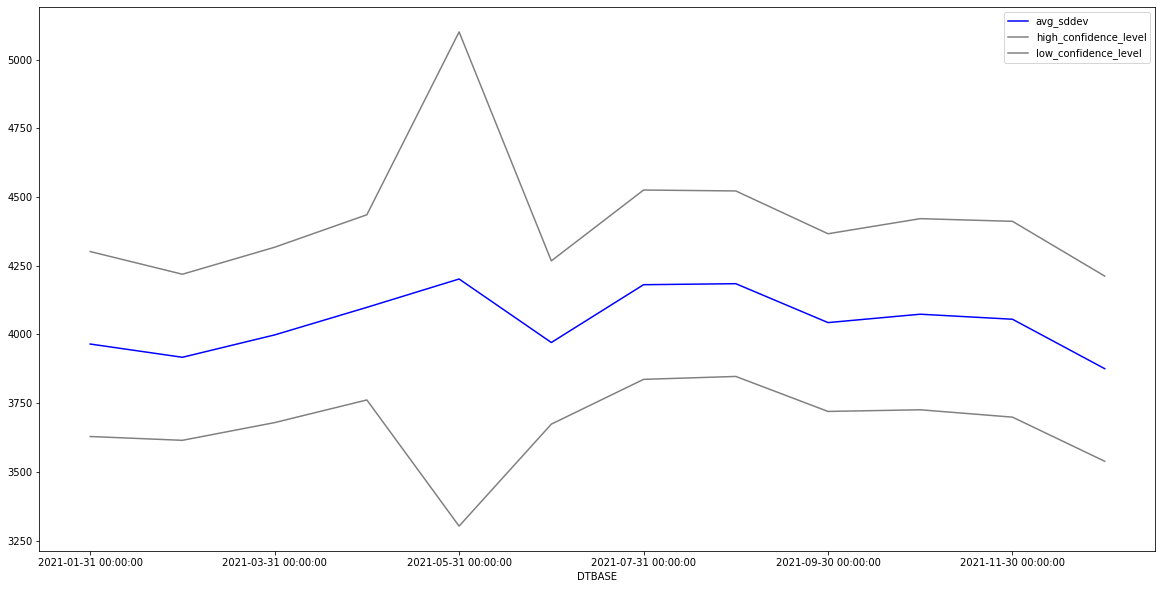

In [13]:
final_tb[['avg_sddev', 'high_confidence_level', 'low_confidence_level']].plot.line(
    color={
        'avg_sddev': 'blue',
        'high_confidence_level': 'gray',
        'low_confidence_level': 'gray'
    },
    figsize=(20,10)
)

Analisando o gráfico acima podemos notar uma distorção nos valores das bandas de confiança para o mês de Maio. Isso se deu pelo fato da quantidade de elementos ter diminuído drásticamente

<AxesSubplot:xlabel='DTBASE'>

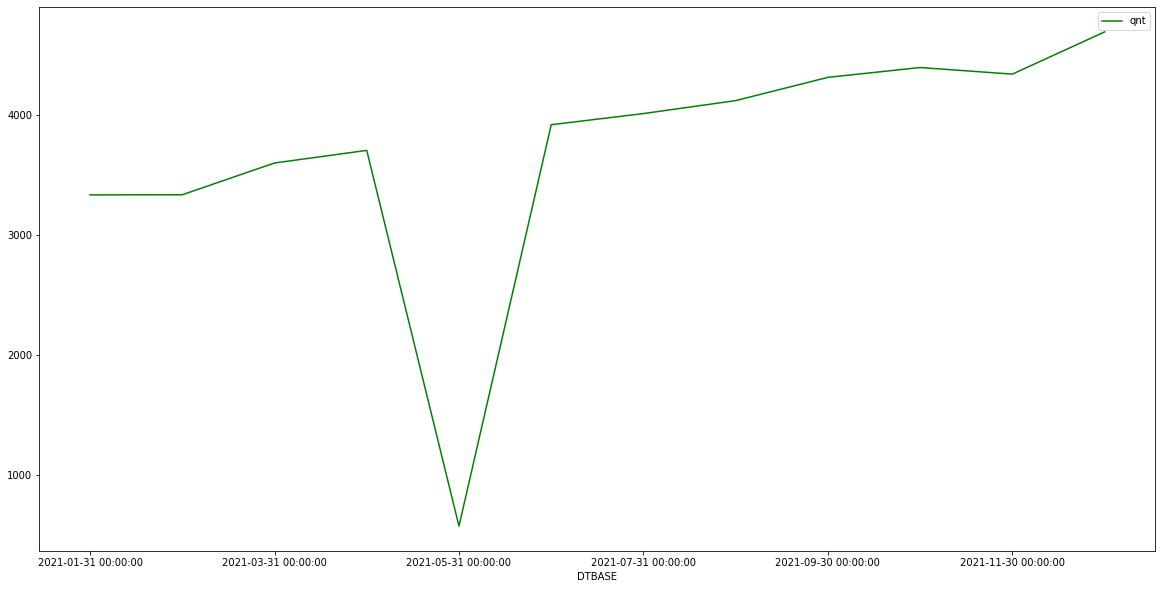

In [14]:
consol_table[['DTBASE', 'qnt']].set_index('DTBASE').plot.line(
    color={
        'qnt': 'green'
    },
    figsize=(20,10)
)